In [2]:
import numpy as np

**Module** is an abstract class which defines fundamental methods necessary for a training a neural network. You do not need to change anything here, just read the comments.

In [3]:
class Module(object):
    def __init__ (self):
        self.output = None
        self.gradInput = None
        self.training = True
    """
    Basically, you can think of a module as of a something (black box) 
    which can process `input` data and produce `ouput` data.
    This is like applying a function which is called `forward`: 
        
        output = module.forward(input)
    
    The module should be able to perform a backward pass: to differentiate the `forward` function. 
    More, it should be able to differentiate it if is a part of chain (chain rule).
    The latter implies there is a gradient from previous step of a chain rule. 
    
        gradInput = module.backward(input, gradOutput)
    """
    
    def forward(self, input):
        """
        Takes an input object, and computes the corresponding output of the module.
        """
        return self.updateOutput(input)

    def backward(self,input, gradOutput):
        """
        Performs a backpropagation step through the module, with respect to the given input.
        
        This includes 
         - computing a gradient w.r.t. `input` (is needed for further backprop),
         - computing a gradient w.r.t. parameters (to update parameters while optimizing).
        """
        self.updateGradInput(input, gradOutput)
        self.accGradParameters(input, gradOutput)
        return self.gradInput
    

    def updateOutput(self, input):
        """
        Computes the output using the current parameter set of the class and input.
        This function returns the result which is stored in the `output` field.
        
        Make sure to both store the data in `output` field and return it. 
        """
        
        # The easiest case:
            
        # self.output = input 
        # return self.output
        
        pass

    def updateGradInput(self, input, gradOutput):
        """
        Computing the gradient of the module with respect to its own input. 
        This is returned in `gradInput`. Also, the `gradInput` state variable is updated accordingly.
        
        The shape of `gradInput` is always the same as the shape of `input`.
        
        Make sure to both store the gradients in `gradInput` field and return it.
        """
        
        # The easiest case:
        
        # self.gradInput = gradOutput 
        # return self.gradInput
        
        pass   
    
    def accGradParameters(self, input, gradOutput):
        """
        Computing the gradient of the module with respect to its own parameters.
        No need to override if module has no parameters (e.g. ReLU).
        """
        pass
    
    def zeroGradParameters(self): 
        """
        Zeroes `gradParams` variable if the module has params.
        """
        pass
        
    def getParameters(self):
        """
        Returns a list with its parameters. 
        If the module does not have parameters return empty list. 
        """
        return []
        
    def getGradParameters(self):
        """
        Returns a list with gradients with respect to its parameters. 
        If the module does not have parameters return empty list. 
        """
        return []
    
    def training(self):
        """
        Sets training mode for the module.
        Training and testing behaviour differs for Dropout, BatchNorm.
        """
        self.training = True
    
    def evaluate(self):
        """
        Sets evaluation mode for the module.
        Training and testing behaviour differs for Dropout, BatchNorm.
        """
        self.training = False
    
    def __repr__(self):
        """
        Pretty printing. Should be overrided in every module if you want 
        to have readable description. 
        """
        return "Module"

# Sequential container

**Define** a forward and backward pass procedures.

In [4]:
class Sequential(Module):
    """
         This class implements a container, which processes `input` data sequentially. 
         
         `input` is processed by each module (layer) in self.modules consecutively.
         The resulting array is called `output`. 
    """
    
    def __init__ (self):
        super(Sequential, self).__init__()
        self.modules = []
   
    def add(self, module):
        """
        Adds a module to the container.
        """
        self.modules.append(module)

    def updateOutput(self, input):
        """
        Basic workflow of FORWARD PASS:
        
            y_0    = module[0].forward(input)
            y_1    = module[1].forward(y_0)
            ...
            output = module[n-1].forward(y_{n-2})   
            
            
        Just write a little loop. 
        """

        self.outputs = [input]
        for module in self.modules:
            self.outputs.append(module.forward(self.outputs[-1]))
        self.output = self.outputs[-1]
        return self.output

    def backward(self, input, gradOutput):
        """
        Workflow of BACKWARD PASS:
            
            g_{n-1} = module[n-1].backward(y_{n-2}, gradOutput)
            g_{n-2} = module[n-2].backward(y_{n-3}, g_{n-1})
            ...
            g_1 = module[1].backward(y_0, g_2)   
            gradInput = module[0].backward(input, g_1)   
             
             
        !!!
                
        To ech module you need to provide the input, module saw while forward pass, 
        it is used while computing gradients. 
        Make sure that the input for `i-th` layer the output of `module[i]` (just the same input as in forward pass) 
        and NOT `input` to this Sequential module. 
        
        !!!
        
        """
        grad = gradOutput
        for module, output in reversed(zip(self.modules, self.outputs[:-1])):
            grad = module.backward(output, grad)
        self.gradInput = grad
        return self.gradInput
      

    def zeroGradParameters(self): 
        for module in self.modules:
            module.zeroGradParameters()
    
    def getParameters(self):
        """
        Should gather all parameters in a list.
        """
        return [x.getParameters() for x in self.modules]
    
    def getGradParameters(self):
        """
        Should gather all gradients w.r.t parameters in a list.
        """
        return [x.getGradParameters() for x in self.modules]
    
    def __repr__(self):
        string = "".join([str(x) + '\n' for x in self.modules])
        return string
    
    def __getitem__(self,x):
        return self.modules.__getitem__(x)

# Layers

- input:   **`batch_size x n_feats1`**
- output: **`batch_size x n_feats2`**

In [133]:
class Linear(Module):
    """
    A module which applies a linear transformation 
    A common name is fully-connected layer, InnerProductLayer in caffe. 
    
    The module should work with 2D input of shape (n_samples, n_feature).
    """
    def __init__(self, n_in, n_out):
        super(Linear, self).__init__()
       
        # This is a nice initialization
        stdv = 1./np.sqrt(n_in)
        self.W = np.random.uniform(-stdv, stdv, size = (n_out, n_in))
        self.b = np.random.uniform(-stdv, stdv, size = n_out)
        
        self.gradW = np.zeros_like(self.W)
        self.gradb = np.zeros_like(self.b)
        
    def updateOutput(self, input):
        self.output = np.dot(input, self.W.T) + self.b     
        return self.output
    
    def updateGradInput(self, input, gradOutput):
        self.gradInput = gradOutput * self.W
        return self.gradInput
    
    def accGradParameters(self, input, gradOutput):
        self.gradW = np.mean(gradOutput * input.reshape(input.shape[0], -1, 1), axis=0)
        self.gradb = gradOutput
        pass
    
    def zeroGradParameters(self):
        self.gradW.fill(0)
        self.gradb.fill(0)
        
    def getParameters(self):
        return [self.W, self.b]
    
    def getGradParameters(self):
        return [self.gradW, self.gradb]
    
    def __repr__(self):
        s = self.W.shape
        q = 'Linear %d -> %d' %(s[1],s[0])
        return q

This one is probably the hardest but as others only takes 5 lines of code in total. 
- input:   **`batch_size x n_feats`**
- output: **`batch_size x n_feats`**

In [123]:
class SoftMax(Module):
    def __init__(self):
         super(SoftMax, self).__init__()
    
    def updateOutput(self, input):
        # start with normalization for numerical stability
        self.output = np.subtract(input, input.max(axis=1, keepdims=True))
        
        self.output = np.exp(self.output) / np.sum(np.exp(self.output), axis=1, keepdims=True)
        return self.output
    
    def updateGradInput(self, input, gradOutput):
        feature_num = input.shape[1]
        exp = np.exp(input)
        print exp.reshape((-1, feature_num, 1)).shape
        self.gradInput = (np.matmul((exp * np.sum(exp, axis=1, keepdims=True)).reshape((-1, 1, feature_num)), np.eye(feature_num))
                          - np.matmul(exp.reshape((-1, feature_num, 1)), exp.reshape((-1, 1, feature_num)))) / np.sum(exp, axis=1, keepdims=True).reshape((-1, 1, 1))**2
        return self.gradInput
    
    def __repr__(self):
        return "SoftMax"

Implement [**dropout**](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf). The idea and implementation is really simple: just multimply the input by $Bernoulli(p)$ mask. 

This is a very cool regularizer. In fact, when you see your net is overfitting try to add more dropout.

While training (`self.training == True`) it should sample a mask on each iteration (for every batch). When testing this module should implement identity transform i.e. `self.output = input`.

- input:   **`batch_size x n_feats`**
- output: **`batch_size x n_feats`**

In [98]:
class Dropout(Module):
    def __init__(self, p=0.5):
        super(Dropout, self).__init__()
        
        self.p = p
        self.mask = None
        
    def updateOutput(self, input):
        self.output = input
        self.mask = np.random.binomial(1, self.p, input.shape)
        if self.training:
            np.mul(self.output, self.mask, out=self.output)
        return self.output
    
    def updateGradInput(self, input, gradOutput):
        self.gradInput = gradOutput * self.mask
        return self.gradInput
        
    def __repr__(self):
        return "Dropout"

# Activation functions

Here's the complete example for the **Rectified Linear Unit** non-linearity (aka **ReLU**): 

In [99]:
class ReLU(Module):
    def __init__(self):
         super(ReLU, self).__init__()
    
    def updateOutput(self, input):
        self.output = np.maximum(input, 0)
        return self.output
    
    def updateGradInput(self, input, gradOutput):
        self.gradInput = np.multiply(gradOutput , input > 0)
        return self.gradInput
    
    def __repr__(self):
        return "ReLU"

Implement [**Leaky Rectified Linear Unit**](http://en.wikipedia.org/wiki%2FRectifier_%28neural_networks%29%23Leaky_ReLUs). Expriment with slope. 

In [100]:
class LeakyReLU(Module):
    def __init__(self, slope = 0.03):
        super(LeakyReLU, self).__init__()
            
        self.slope = slope
        
    def updateOutput(self, input):
        if input >= 0:
            self.output = input
        else:
            self.output = self.slope * input
        return  self.output
    
    def updateGradInput(self, input, gradOutput):
        self.gradInput = np.multiply(gradOutput , input > 0) + self.slope * np.multiply(gradOutput , input < 0)
        return self.gradInput
    
    def __repr__(self):
        return "LeakyReLU"

# Criterions

Criterions are used to score the models answers. 

In [101]:
class Criterion(object):
    def __init__ (self):
        self.output = None
        self.gradInput = None
        
    def forward(self, input, target):
        """
            Given an input and a target, compute the loss function 
            associated to the criterion and return the result.
            
            For consistency this function should not be overrided,
            all the code goes in `updateOutput`.
        """
        return self.updateOutput(input, target)

    def backward(self, input, target):
        """
            Given an input and a target, compute the gradients of the loss function
            associated to the criterion and return the result. 

            For consistency this function should not be overrided,
            all the code goes in `updateGradInput`.
        """
        return self.updateGradInput(input, target)
    
    def updateOutput(self, input, target):
        """
        Function to override.
        """
        return self.output

    def updateGradInput(self, input, target):
        """
        Function to override.
        """
        return self.gradInput   

    def __repr__(self):
        """
        Pretty printing. Should be overrided in every module if you want 
        to have readable description. 
        """
        return "Criterion"

The **MSECriterion**, which is basic L2 norm usually used for regression, is implemented here for you.

In [102]:
class MSECriterion(Criterion):
    def __init__(self):
        super(MSECriterion, self).__init__()
        
    def updateOutput(self, input, target):   
        self.output = np.sum(np.power(input - target,2)) / input.shape[0]
        return self.output 
 
    def updateGradInput(self, input, target):
        self.gradInput  = (input - target) * 2 / input.shape[0]
        return self.gradInput

    def __repr__(self):
        return "MSECriterion"

You task is to implement the **ClassNLLCriterion**. It should implement [multiclass log loss](http://scikit-learn.org/stable/modules/model_evaluation.html#log-loss). Nevertheless there is a sum over `y` (target) in that formula, 
remember that targets are one-hot encoded. This fact simplifies the computations a lot. Note, that criterions are the only places, where you divide by batch size. 

In [103]:
class ClassNLLCriterion(Criterion):
    def __init__(self):
        a = super(ClassNLLCriterion, self)
        super(ClassNLLCriterion, self).__init__()
        
    def updateOutput(self, input, target): 
        
        # Use this trick to avoid numerical errors
        eps = 1e-15 
        input_clamp = np.clip(input, eps, 1 - eps)
        
        self.output = np.sum(target * np.log(input_clamp)) / input.shape[0]
        return self.output

    def updateGradInput(self, input, target):
        
        # Use this trick to avoid numerical errors
        input_clamp = np.maximum(1e-15, np.minimum(input, 1 - 1e-15) )
                
        self.gradInput = np.mean(target / input_clamp, axis=0)
        return self.gradInput
    
    def __repr__(self):
        return "ClassNLLCriterion"

In [104]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

In [105]:
def sgd_momentum(x, dx, config, state):
    """
        This is a very ugly implementation of sgd with momentum 
        just to show an example how to store old grad in state.
        
        config:
            - momentum
            - learning_rate
        state:
            - old_grad
    """
    
    # x and dx have complex structure, old dx will be stored in a simpler one
    state.setdefault('old_grad', {})
    
    i = 0 
    for cur_layer_x, cur_layer_dx in zip(x,dx): 
        for cur_x, cur_dx in zip(cur_layer_x,cur_layer_dx):
            
            cur_old_grad = state['old_grad'].setdefault(i, np.zeros_like(cur_dx))
            
            np.add(config['momentum'] * cur_old_grad, config['learning_rate'] * cur_dx, out = cur_old_grad)
            
            cur_x -= cur_old_grad
            i += 1     

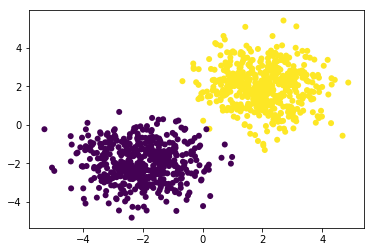

In [106]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

In [144]:
net = Sequential()
net.add(Linear(2, 2))
net.add(SoftMax())

creterion = ClassNLLCriterion()

print(net)

# Test something like that then 

# net = Sequential()
# net.add(Linear(2, 4))
# net.add(ReLU())
# net.add(Linear(4, 2))
# net.add(SoftMax())

Linear 2 -> 2
SoftMax



In [145]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [146]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

In [147]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

(128, 2, 1)


ValueError: non-broadcastable output operand with shape (2,) doesn't match the broadcast shape (128,2,2)